# Patents linked to Kent State University publications
_(Created in June 2019)_

This notebook is dependent on the following libraries

In [1]:
import dimcli
from dimcli.shortcuts import dslquery, dslqueryall
import pandas as pd
from pandas.io.json import json_normalize
import plotly_express as px
from plotly.offline import init_notebook_mode # needed for exports 
init_notebook_mode(connected=True)
import time

___
# 1. Data Extraction and Preparation

In [2]:
GRIDID = "grid.258518.3"
YEAR_START = "2009"

In [3]:
df_all_pubs_per_year = dslquery(f"""search publications where research_orgs.id="{GRIDID}"return year limit 1000""").as_dataframe()

In [4]:
pubs_details = dslqueryall(f"""search publications where research_orgs.id="{GRIDID}" and year>="{YEAR_START}" return publications[basics+FOR]""")
df_pubs_details = pubs_details.as_dataframe()

1000 / 8958
2000 / 8958
3000 / 8958
4000 / 8958
5000 / 8958
6000 / 8958
7000 / 8958
8000 / 8958
8958 / 8958


Create a new list of publications with simplifed FOR data

In [5]:
# ensure that all pubs have a valid (empty, even) FOR value 
# also remove the FOR digit prefix to improve legibility
for x in pubs_details.publications:
    if not 'FOR' in x:
        x['FOR'] = ""
    else:
        x['FOR'] = [{'name' : x['name'][5:]} for x in x['FOR']] 
df_pubs_for = json_normalize(pubs_details.publications, record_path=['FOR'], meta=["id", "type", ["journal", "title"], "year"], errors='ignore', record_prefix='for_')

Get the patents infos using the publications 

In [6]:
# query structure is:
# d=dslquery(f"""search patents where publication_ids in ["pub.1111511314","pub.1113174788","pub.1111902055"] return patents limit 1000""")

from itertools import islice
def chunks_of(data, size):
    it = iter(data)
    chunk = list(islice(it, size))
    while chunk:
        yield chunk
        chunk = list(islice(it, size))

SIZE = 400

def run(ids_list):
    patents_out, n  = [], 0
    for chunk in chunks_of(ids_list, SIZE): # chunks of 200 args
        n += 1
        temp = ','.join(['"{}"'.format(i) for i in chunk])
        data = dslquery(f"""search patents where publication_ids in [{temp}] return patents[basics+publication_ids+FOR] limit 1000""")
        patents_out += data.patents
        print("[log] ", n*SIZE, " pubs > patents: ", len(data.patents))
        time.sleep(1)
    return patents_out
        
patents_list = run(list(df_pubs_details['id']))

[log]  400  pubs > patents:  0
[log]  800  pubs > patents:  0
[log]  1200  pubs > patents:  0
[log]  1600  pubs > patents:  0
[log]  2000  pubs > patents:  0
[log]  2400  pubs > patents:  0
[log]  2800  pubs > patents:  0
[log]  3200  pubs > patents:  0
[log]  3600  pubs > patents:  4
[log]  4000  pubs > patents:  1
[log]  4400  pubs > patents:  6
[log]  4800  pubs > patents:  6
[log]  5200  pubs > patents:  6
[log]  5600  pubs > patents:  5
[log]  6000  pubs > patents:  10
[log]  6400  pubs > patents:  6
[log]  6800  pubs > patents:  8
[log]  7200  pubs > patents:  10
[log]  7600  pubs > patents:  8
[log]  8000  pubs > patents:  25
[log]  8400  pubs > patents:  20
[log]  8800  pubs > patents:  79
[log]  9200  pubs > patents:  8


After going through all publications and extracting related patents, let's save the patents data so that we can use it later:

In [9]:
df_patent_details = pd.DataFrame().from_dict(patents_list)
# save to CSV
df_patent_details.to_csv("data/KSU_patents_by_id.csv")
# display top 3 rows
df_patent_details.head(3)

FOR  \
0  [{'id': '2471', 'name': '0306 Physical Chemist...   
1  [{'id': '2447', 'name': '0303 Macromolecular a...   
2  [{'id': '2837', 'name': '0903 Biomedical Engin...   

                                      assignee_names  \
0  [Audi AG, SHOEMAKER KRISTA MARIE, DARLING ROBE...   
1                                 [Audi AG, AUDI AG]   
2                       [WISCONSIN ALUMNI RES FOUND]   

                                           assignees filing_status  \
0  [{'id': 'grid.423767.3', 'name': 'Audi (German...   Application   
1  [{'id': 'grid.423767.3', 'name': 'Audi (German...         Grant   
2  [{'id': 'grid.453773.1', 'acronym': 'WARF', 'n...   Application   

   granted_year                 id  \
0           NaN  US-20130330657-A1   
1        2018.0      US-9923223-B2   
2           NaN   WO-2017218635-A2   

                                      inventor_names publication_date  \
0  [Krista Marie Shoemaker, Robert Mason Darling,...       2013-12-12   
1                    [Zhiwei Yang, Mallika Gummalla]       2018-03-20   
2  [ABBOTT, NICHOLAS, KIM, YOUNGKI, WANG, XIAOGUA...       2017-12-21   

                                     publication_ids  times_cited  \
0                                   [pub.1055134419]            3   
1  [pub.1050216645, pub.1003485683, pub.102928896...            0   
2  [pub.1030314468, pub.1016708652, pub.100230501...            0   

                                               title  year  
0  UNITIZED ELECTRODE ASSEMBLY WITH HIGH EQUIVALE...  2011  
1  Electrolyte membrane, dispersion and method th...  2012  
2  ACTIVATED RELEASE OF TARGET MATERIAL TRAPPED I...  2017

We also want to normalise the assignees data in order to analyse it further later on (ps: first we need to make the assigness data structure more regular)

In [10]:
for x in patents_list:
    if not 'assignees' in x:
        x['assignees'] = []
df_patents_assignees = json_normalize(patents_list, record_path=['assignees'], meta=['id', 'year', 'title'], meta_prefix="grant_")
# save to CSV 
df_patents_assignees.to_csv("data/KSU_patents_by_assignees.csv")
df_patents_assignees.head()

acronym   country_name             id                                  name  \
0     NaN        Germany  grid.423767.3                        Audi (Germany)   
1     UTC  United States  grid.427377.2   United Technologies (United States)   
2     NaN        Germany  grid.423767.3                        Audi (Germany)   
3    WARF  United States  grid.453773.1  Wisconsin Alumni Research Foundation   
4     NaN          Japan  grid.462975.b      Toyota Motor Corporation (Japan)   

            grant_id  grant_year  \
0  US-20130330657-A1        2011   
1  US-20130330657-A1        2011   
2      US-9923223-B2        2012   
3   WO-2017218635-A2        2017   
4      US-9923224-B2        2012   

                                         grant_title  
0  UNITIZED ELECTRODE ASSEMBLY WITH HIGH EQUIVALE...  
1  UNITIZED ELECTRODE ASSEMBLY WITH HIGH EQUIVALE...  
2  Electrolyte membrane, dispersion and method th...  
3  ACTIVATED RELEASE OF TARGET MATERIAL TRAPPED I...  
4       Proton exchange material and method therefor

Let's do the same type of normalization for FOR codes 

In [11]:
for x in patents_list:
    if not 'FOR' in x:
        x['FOR'] = ""
    else:
        x['FOR'] = [{'name' : x['name'][5:]} for x in x['FOR']] 
df_patents_for = json_normalize(patents_list, record_path=['FOR'], meta=["id", "year", "title"], errors='ignore', record_prefix='for_')
# save to CSV 
df_patents_for.to_csv("data/KSU_patents_by_FOR.csv")
df_patents_for.head()

for_name                 id  year  \
0   Physical Chemistry (incl. Structural)  US-20130330657-A1  2011   
1  Macromolecular and Materials Chemistry      US-9923223-B2  2012   
2                  Biomedical Engineering   WO-2017218635-A2  2017   
3  Macromolecular and Materials Chemistry      US-9923224-B2  2012   
4                                Genetics      US-9701675-B2  2016   

                                               title  
0  UNITIZED ELECTRODE ASSEMBLY WITH HIGH EQUIVALE...  
1  Electrolyte membrane, dispersion and method th...  
2  ACTIVATED RELEASE OF TARGET MATERIAL TRAPPED I...  
3       Proton exchange material and method therefor  
4  Activation of TRPV4 ion channel by physical st...

Finally, let's create another publications index, including only the KSU publications cited by the patents extracted above. 

In [12]:
# extract pubs from patents list
pubs_referenced_from_patents = []
for x in patents_list:
    if x['publication_ids']:
        pubs_referenced_from_patents += x['publication_ids']
# remove duplicates
pubs_referenced_from_patents = list(set(pubs_referenced_from_patents))
len(pubs_referenced_from_patents)

2541

Intersect list of publications from KSU with list of publications mentioned in patents

In [13]:
df_linked_pubs =  df_pubs_details[df_pubs_details['id'].isin(pubs_referenced_from_patents)]
df_linked_pubs.reset_index(drop=True)
# save to CSV 
df_linked_pubs.to_csv("data/KSU_pubs_linked_to_patents.csv")
df_linked_pubs.head()


FOR  \
3264                                                NaN   
3580  [{'id': '2471', 'name': '0306 Physical Chemist...   
3701  [{'id': '2581', 'name': '0601 Biochemistry and...   
4168  [{'id': '2471', 'name': '0306 Physical Chemist...   
4200  [{'id': '3142', 'name': '1112 Oncology and Car...   

                                    author_affiliations              id issue  \
3264  [[{'first_name': 'Ruifeng', 'last_name': 'Zhou...  pub.1055134419     7   
3580  [[{'first_name': 'Zhi-gang', 'last_name': 'Zhe...  pub.1050744992  7594   
3701  [[{'first_name': 'Ravi K.', 'last_name': 'Adap...  pub.1051993472     3   
4168  [[{'first_name': 'Jian', 'last_name': 'Liu', '...  pub.1028460971     8   
4200  [[{'first_name': 'Xiaozhou', 'last_name': 'Li'...  pub.1033052794    14   

                                                journal        pages  \
3264   {'id': 'jour.1045236', 'title': 'ACS Catalysis'}    4720-4728   
3580          {'id': 'jour.1018957', 'title': 'Nature'}          352   
3701        {'id': 'jour.1097543', 'title': 'Oncogene'}          314   
4168  {'id': 'jour.1031408', 'title': 'Nature Materi...      763-774   
4200  {'id': 'jour.1030495', 'title': 'Optics Express'}  18361-18372   

                                                  title     type volume  year  
3264  Determination of the Electron Transfer Number ...  article      6  2016  
3580  Three-dimensional control of the helical axis ...  article    531  2016  
3701  Activation of mechanosensitive ion channel TRP...  article     35  2016  
4168  Molecular-based design and emerging applicatio...  article     14  2015  
4200  Noninvasive liver diseases detection based on ...  article     23  2015

Also, create a version of `df_linked_pubs` with simplified FOR codes so that it's easier to visualise.

In [14]:
df_linked_pubs_for =  df_pubs_for[df_pubs_for['id'].isin(pubs_referenced_from_patents)]
df_linked_pubs_for.reset_index(drop=True)
df_linked_pubs_for.head()

for_name              id     type  \
3715   Physical Chemistry (incl. Structural)  pub.1050744992  article   
3833           Biochemistry and Cell Biology  pub.1051993472  article   
4304   Physical Chemistry (incl. Structural)  pub.1028460971  article   
4305  Macromolecular and Materials Chemistry  pub.1028460971  article   
4338             Oncology and Carcinogenesis  pub.1033052794  article   

         journal.title  year  
3715            Nature  2016  
3833          Oncogene  2016  
4304  Nature Materials  2015  
4305  Nature Materials  2015  
4338    Optics Express  2015

---
#### That's it - now it's time to create some visualizations!
___

# 2. Data Analysis

## 2.1 Publications

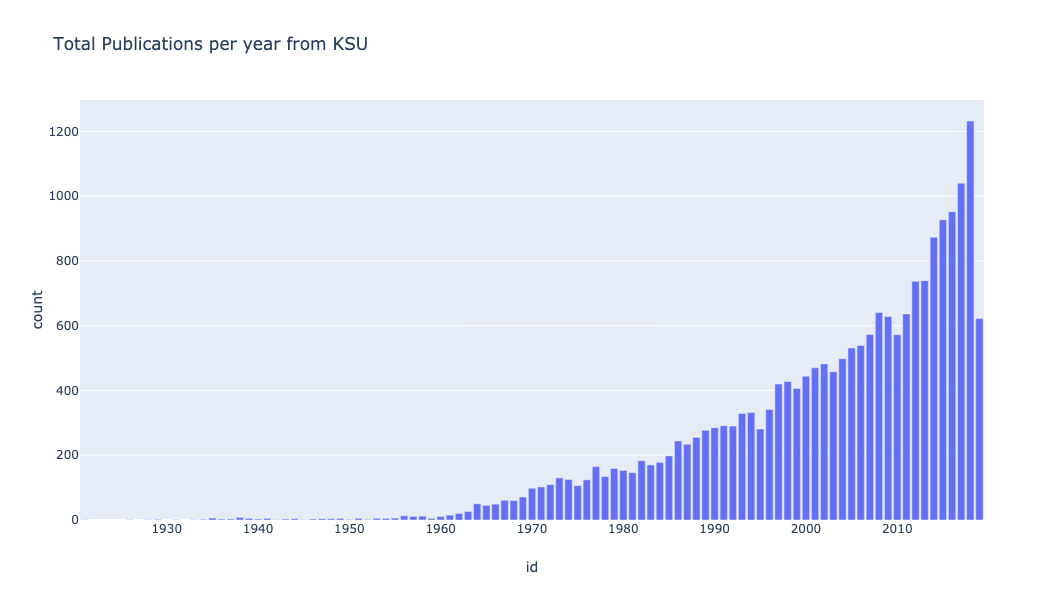

In [15]:
px.bar(df_all_pubs_per_year, x="id", y="count", title="Total Publications per year from KSU")

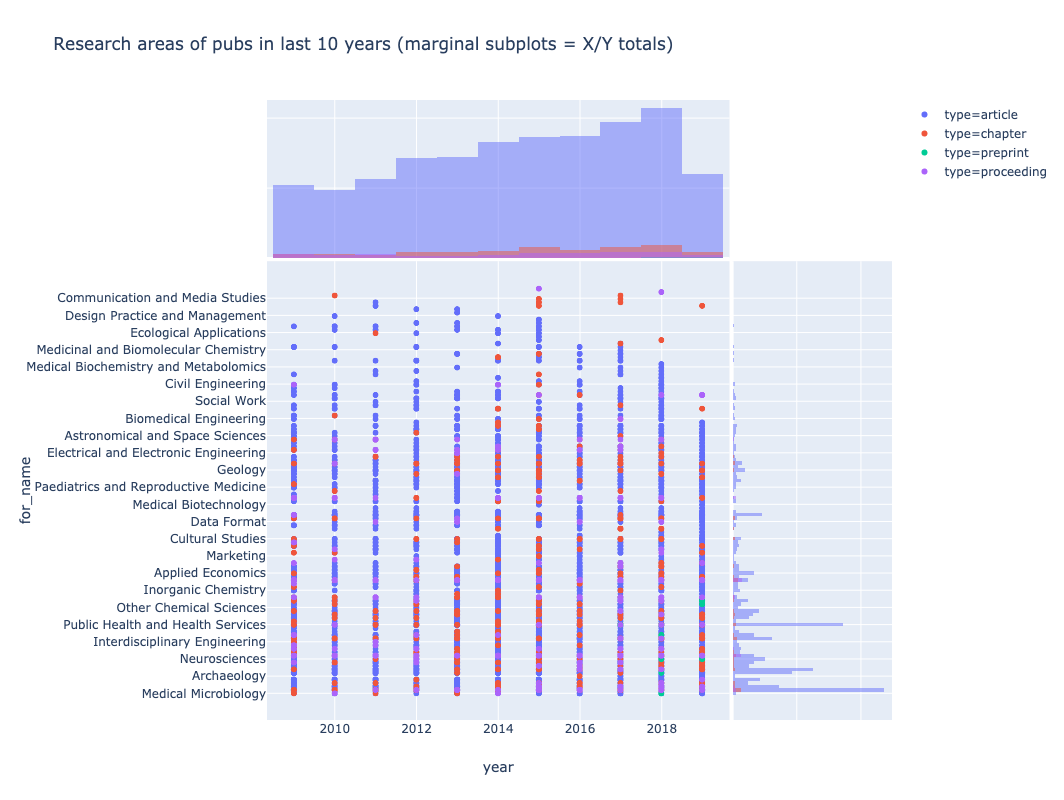

In [16]:
px.scatter(df_pubs_for, x="year", y="for_name", color="type", hover_name="for_name", marginal_x="histogram", marginal_y="histogram", height=800, title="Research areas of pubs in last 10 years (marginal subplots = X/Y totals)")

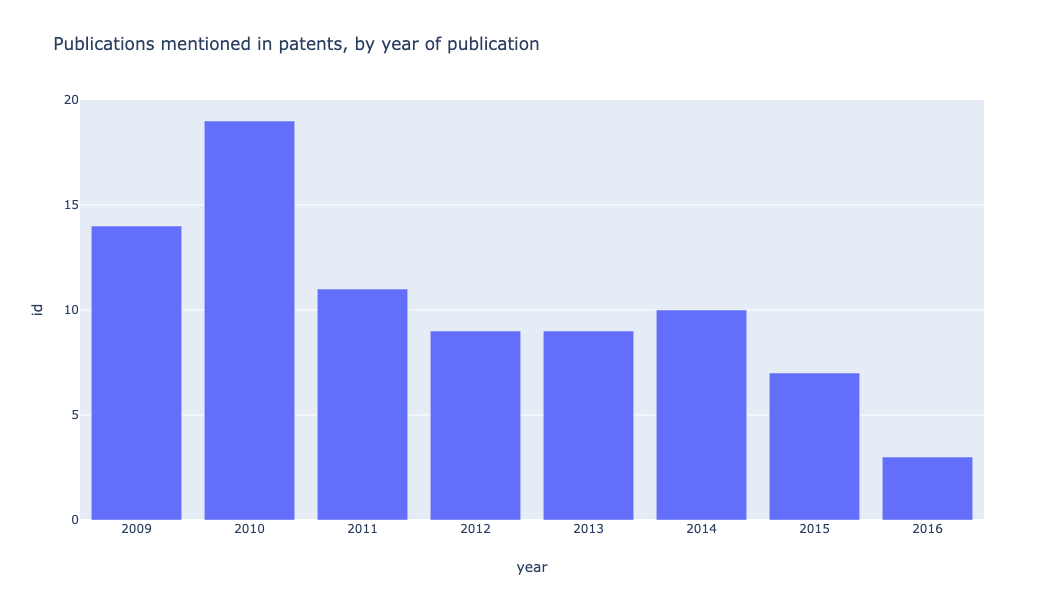

In [17]:
px.bar(df_linked_pubs.groupby('year',  as_index=False).count(), x="year", y="id", title="Publications mentioned in patents, by year of publication")

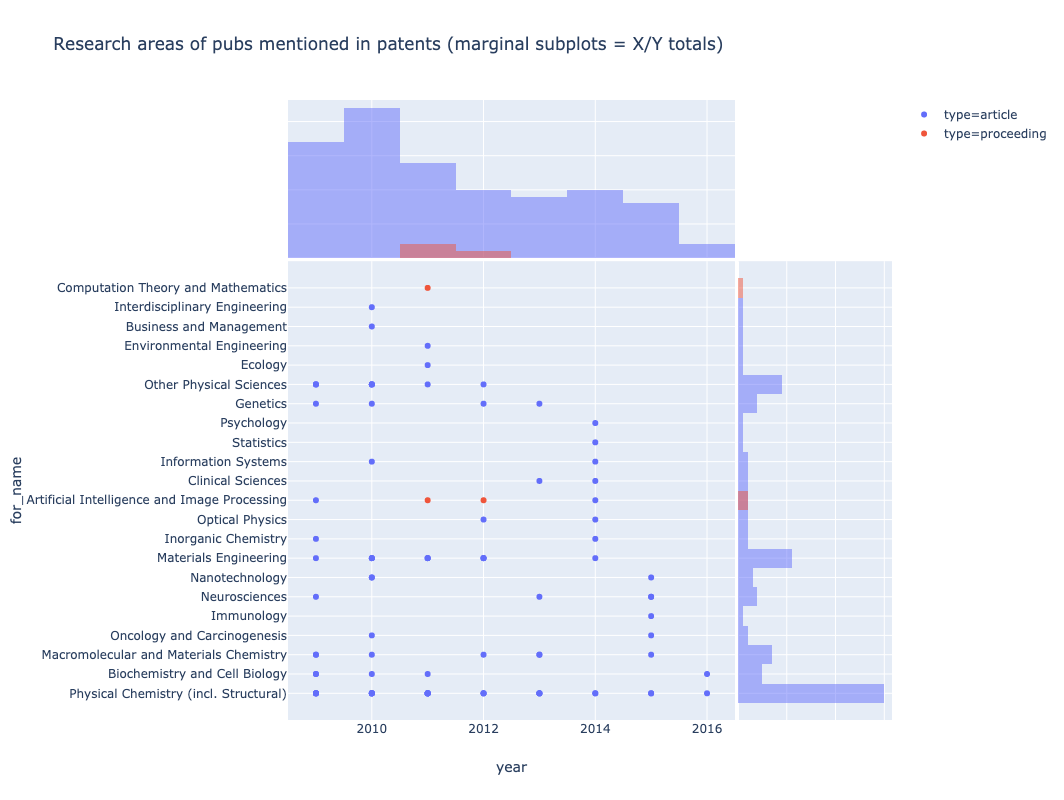

In [18]:
px.scatter(df_linked_pubs_for, x="year", y="for_name", color="type", hover_name="for_name", marginal_x="histogram", marginal_y="histogram", height=800, title="Research areas of pubs mentioned in patents (marginal subplots = X/Y totals)")

## 2.2 Patents

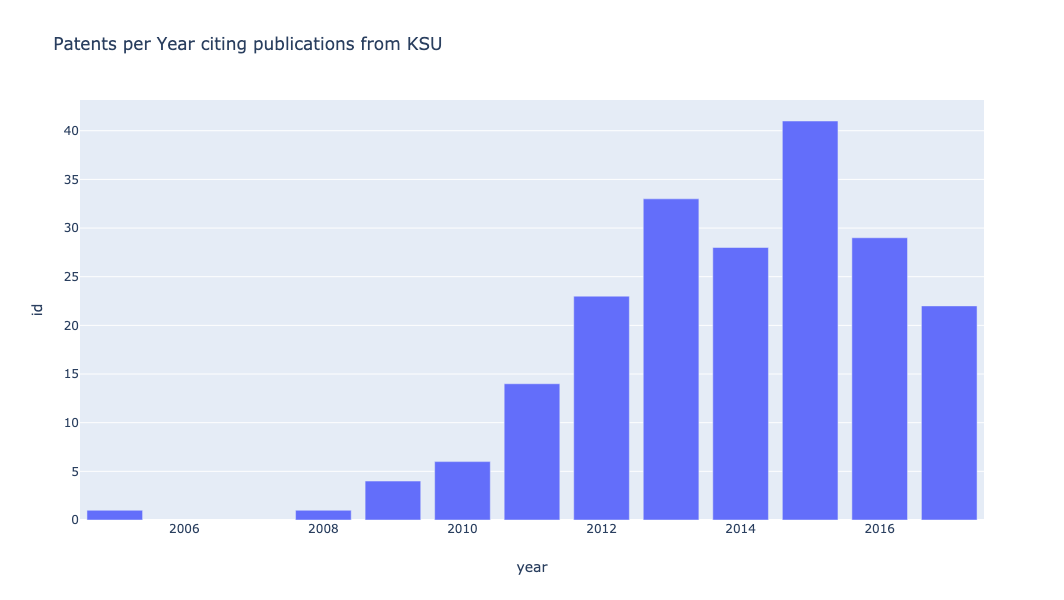

In [19]:
px.bar(df_patent_details.groupby('year',  as_index=False).count(),  x="year", y="id",  title="Patents per Year citing publications from KSU")

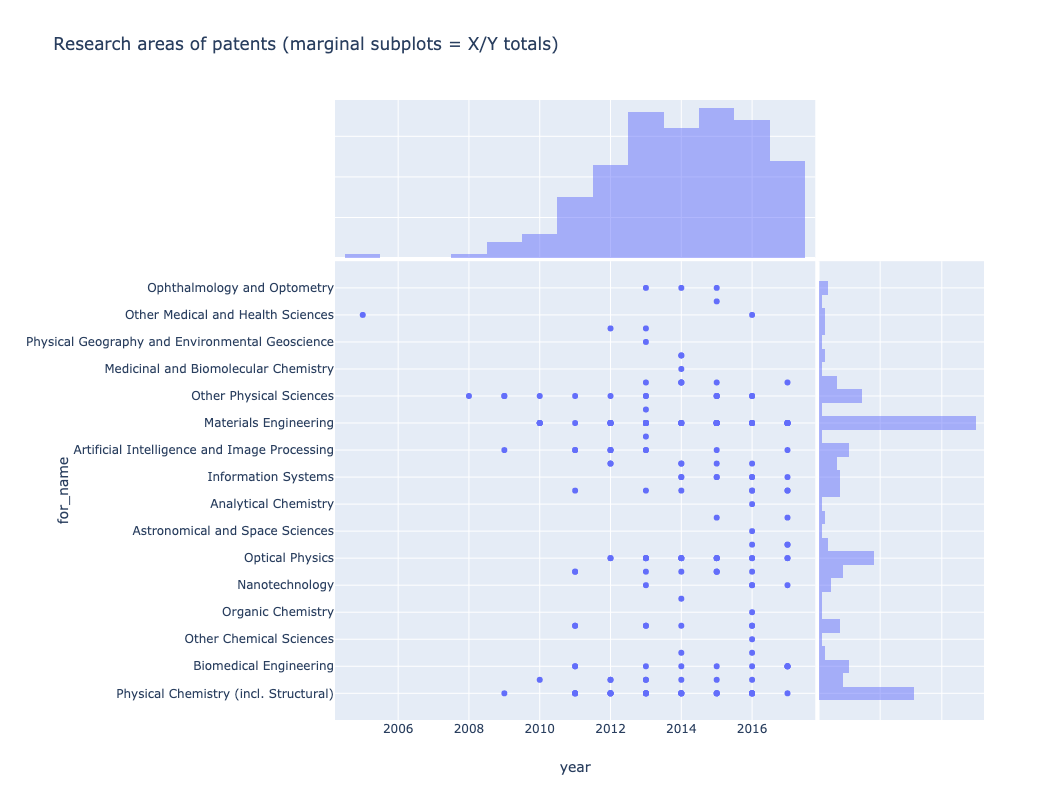

In [20]:
px.scatter(df_patents_for, x="year", y="for_name", hover_name="for_name", marginal_x="histogram", marginal_y="histogram", height=800, title="Research areas of patents (marginal subplots = X/Y totals)")

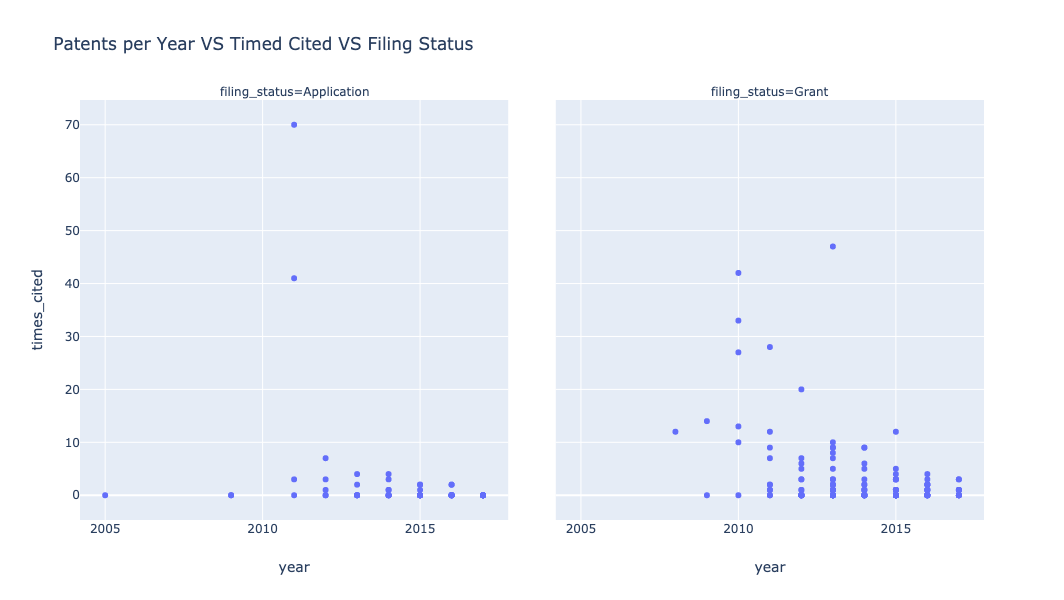

In [21]:
px.scatter(df_patent_details, x="year", y="times_cited", hover_name="title",  hover_data=['id'], facet_col="filing_status", title="Patents per Year VS Timed Cited VS Filing Status")

## 2.3 Assignees of patents

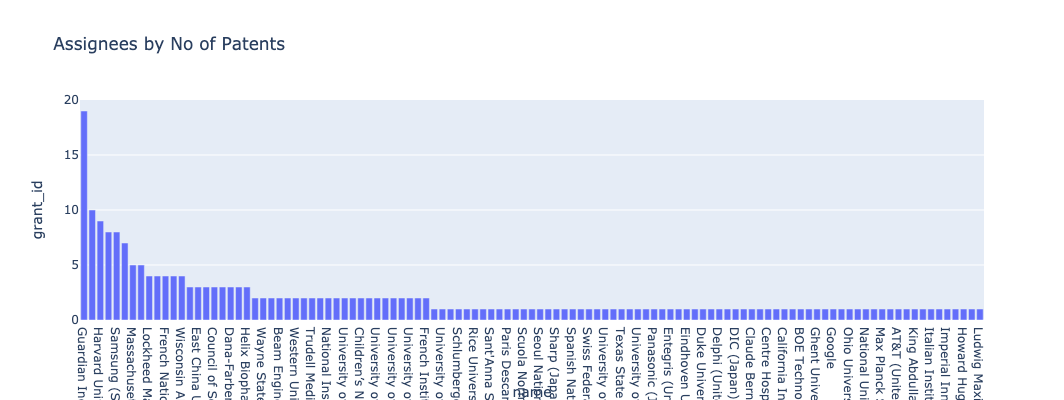

In [22]:
px.bar(df_patents_assignees.groupby('name',  as_index=False).count().sort_values(by="grant_id", ascending=False),  x="name", y="grant_id", hover_name="name",  height=400,  title="Assignees by No of Patents")

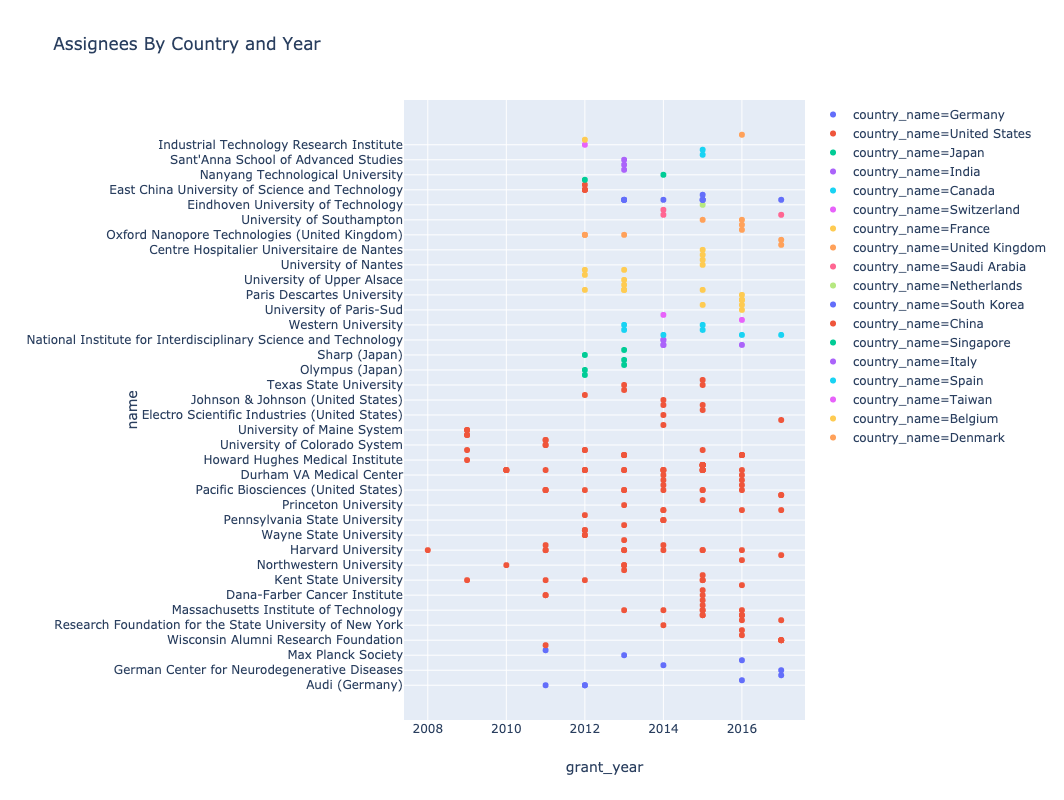

In [23]:
px.scatter(df_patents_assignees,  x="grant_year", y="name", color="country_name", hover_name="name",  hover_data=["id"],  height=800, title="Assignees By Country and Year")